Nutrition Bot/Assistant using LangGraph.

The LangGraph flow diagram is attached below:










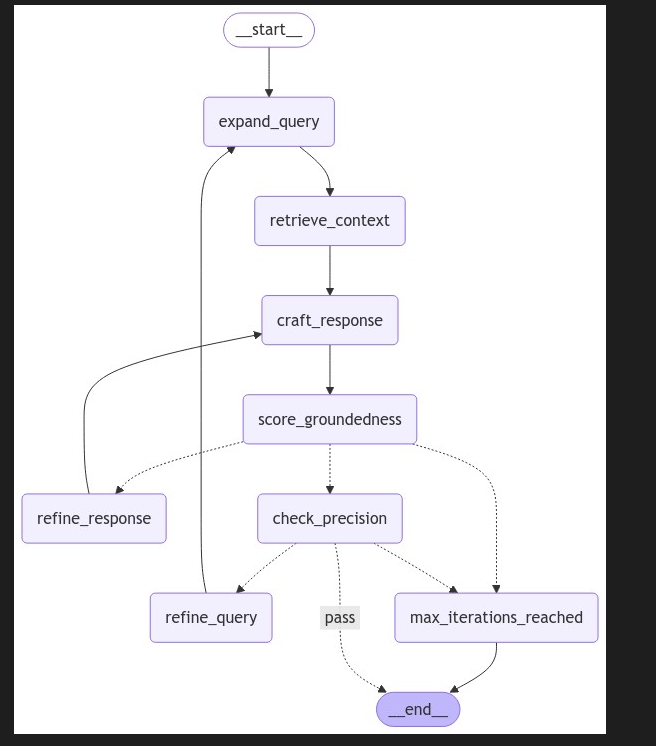

In [ ]:
# Install necessary packages
!pip install langchain langgraph faiss-cpu llama-index llama-parse groq streamlit --quiet
!pip install langchain-core
!pip install langchain-community
!pip install  langchain-groq

# Importing libs
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from llama_parse import LlamaParse
from langchain.document_loaders import DirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
from langchain_groq import ChatGroq
import os
import shutil
import nest_asyncio
nest_asyncio.apply()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.7/126.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 k

In [ ]:


from google.colab import files

# Upload your 7 PDFs
uploaded = files.upload()

# Optional: move PDFs to a dedicated folder
os.makedirs("npdfs", exist_ok=True)
for filename in uploaded.keys():
    shutil.move(filename, f"npdfs/{filename}")


Saving Nutrition 7.pdf to Nutrition 7.pdf
Saving Nutrition 6.pdf to Nutrition 6.pdf
Saving Nutrition 5.pdf to Nutrition 5.pdf
Saving Nutrition 4.pdf to Nutrition 4.pdf
Saving Nutrition 3.pdf to Nutrition 3.pdf
Saving Nutrition 2.pdf to Nutrition 2.pdf
Saving Nutrition 1.pdf to Nutrition 1.pdf


In [ ]:
from llama_parse import LlamaParse
import os
from pathlib import Path

# Set your Llama Cloud API Key
os.environ["LLAMA_CLOUD_API_KEY"] = "llx-19AxYAnnoGuENvRzXbKpEX8QbCjC6JlSKhVIgWD6pP75UBjs"

# Initialize parser
parser = LlamaParse(
    api_key=os.environ["LLAMA_CLOUD_API_KEY"],
    result_type="markdown",  # You can also try "text" or "json" if supported
    verbose=True,
)

# Collect full file paths of all PDFs in the folder
pdf_folder = Path("npdfs")
pdf_files = list(pdf_folder.glob("*.pdf"))

# Parse them with LlamaParse
docs = parser.load_data(pdf_files)
print(f"Parsed {len(docs)} documents.\n")

print(f"{len(docs)}, {len(pdf_files)}")

# After parsing, check lengths
print(f"Found {len(pdf_files)} PDF files. Parsed {len(docs)} documents.\n")

# Use zip to pair docs and pdf_files safely
for doc, pdf_file in zip(docs, pdf_files):
    print(f"\n--- Document: {pdf_file.name} ---")

    # Rest of your code (metadata, content preview, etc.)
    if hasattr(doc, 'metadata'):
        print("Metadata:", doc.metadata)
    # ... (other print statements)



Parsing files: 100%|██████████| 7/7 [00:24<00:00,  3.43s/it]

Parsed 416 documents.

416, 7
Found 7 PDF files. Parsed 416 documents.


--- Document: Nutrition 2.pdf ---
Metadata: {}

--- Document: Nutrition 3.pdf ---
Metadata: {}

--- Document: Nutrition 5.pdf ---
Metadata: {}

--- Document: Nutrition 6.pdf ---
Metadata: {}

--- Document: Nutrition 1.pdf ---
Metadata: {}

--- Document: Nutrition 7.pdf ---
Metadata: {}

--- Document: Nutrition 4.pdf ---
Metadata: {}


In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
# 1. Convert to LangChain documents first
from langchain_core.documents import Document

langchain_docs = []
for doc in docs:
    content = doc.text if hasattr(doc, 'text') else str(doc)
    metadata = doc.metadata if hasattr(doc, 'metadata') else {}
    langchain_docs.append(Document(page_content=content, metadata=metadata))


# 1. Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # Adjust based on your needs
    chunk_overlap=200,
    length_function=len,
    is_separator_regex=False,
)


# 2. Now split the converted documents
split_docs = text_splitter.split_documents(langchain_docs)

print(f"Split into {len(split_docs)} chunks")

# 2. Create embeddings using open-source model
model_name = "sentence-transformers/paraphrase-multilingual-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}  # Use 'cuda' if you have GPU
encode_kwargs = {'normalize_embeddings': False}

embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

# 3. Create and save FAISS vector store
vector_store = FAISS.from_documents(
    documents=split_docs,
    embedding=embeddings
)

# Save the vector store locally
vector_store.save_local("nutrition_vector_store")
print("Vector store created and saved locally!")

# To load it later:
loaded_vectorstore = FAISS.load_local(
    folder_path="nutrition_vector_store",
    embeddings=embeddings,
    allow_dangerous_deserialization=True  # Explicitly acknowledge the risk
)

Split into 1385 chunks
Vector store created and saved locally!


In [35]:
from typing import TypedDict, Literal
from langgraph.graph import StateGraph, END

# 1. Define enhanced state schema
class AgentState(TypedDict):
    query: str
    expanded_query: str
    context: str
    response: str
    precision_score: float
    groundedness_score: float
    loop_count: int
    max_iter: int = 3  # Default max iterations

# 2. Initialize components with better error handling
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0.1,
    model_name="qwen-qwq-32b",
    api_key="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"
)

# 3. Node functions with state management
def expand_query(state: AgentState):
    """Expand the initial query"""
    return {"expanded_query": f"{state['query']} (expanded using CGSM-D method)"}

def retrieve_context(state: AgentState):
    """Retrieve relevant context from vector store"""
    retriever = FAISS.load_local(
        "nutrition_vector_store",
        embeddings,
        allow_dangerous_deserialization=True
    ).as_retriever(k=3)
    docs = retriever.get_relevant_documents(state["expanded_query"])
    return {"context": "\n".join([d.page_content for d in docs])}

def craft_response(state: AgentState):
    """Generate initial response using LLM"""
    response = llm.invoke(
        f"Context:\n{state['context']}\n\nQuestion: {state['expanded_query']}"
    ).content
    return {"response": response}

def score_groundedness(state: AgentState):
    """Score response groundedness (simplified example)"""
    return {"groundedness_score": 0.85}  # Replace with actual scoring logic

def check_precision(state: AgentState) -> dict:
    """Check precision thresholds"""
    decision = "pass" if (
        state["groundedness_score"] >= 0.8
        and state["loop_count"] < state["max_iter"]
    ) else "refine_query"
    return {"decision": decision}  # Return dict with "decision" key

def refine_query(state: AgentState):
    """Refine query for next iteration"""
    return {
        "expanded_query": f"{state['expanded_query']} [refined]",
        "loop_count": state["loop_count"] + 1
    }

# 4. Build the workflow graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("expand_query", expand_query)
workflow.add_node("retrieve_context", retrieve_context)
workflow.add_node("craft_response", craft_response)
workflow.add_node("score_groundedness", score_groundedness)
workflow.add_node("check_precision", check_precision)
workflow.add_node("refine_query", refine_query)

# Set initial workflow
workflow.set_entry_point("expand_query")

# Main flow
workflow.add_edge("expand_query", "retrieve_context")
workflow.add_edge("retrieve_context", "craft_response")
workflow.add_edge("craft_response", "score_groundedness")
workflow.add_edge("score_groundedness", "check_precision")


# Conditional edges
workflow.add_conditional_edges(
    "check_precision",
    lambda x: x["decision"],  # Directly access the "decision" key
    {"pass": END, "refine_query": "refine_query"}
)


# Refinement loop
workflow.add_edge("refine_query", "expand_query")

# 5. Compile and validate
graph = workflow.compile()

# 6. Execution function
def run_agent(query: str, max_iter: int = 3):
    initial_state = {
        "query": query,
        "expanded_query": "",
        "context": "",
        "response": "",
        "groundedness_score": 0.0,
        "loop_count": 0,
        "max_iter": max_iter
    }

    final_state = None
    for step in graph.stream(initial_state):
        if "__end__" in step:
            final_state = step["__end__"]
            break  # Exit loop once terminated ✅
        else:
            print(f"Step: {list(step.keys())[0]}")
            print(f"Current state: {step}\n")

    if not final_state:
        # Gracefully handle incomplete termination
        final_state = {
            "response": "Workflow terminated unexpectedly",
            **initial_state
        }

    return final_state

In [36]:
# Initialize with your query
result = run_agent("What are the vitamin D rich foods?")

# Get final response
print("\nFinal Response:", result["response"])

Step: expand_query
Current state: {'expand_query': {'expanded_query': 'What are the vitamin D rich foods? (expanded using CGSM-D method)'}}

Step: retrieve_context
Current state: {'retrieve_context': {'context': '# Vitamin D\n\n# Functions\n\n- Vitamin D is needed for the absorption of calcium from foods to keep bones and teeth strong and healthy.\n- Helps your body use calcium and phosphorus, two minerals you need for healthy bones.\n\n# Sources\n\nWe get most of our vitamin D via the action of UV rays from the sunlight on skin.\n\nVitamin D is also provided in small amounts by the diet from oily fish, meat, egg yolk, fortified milk, and margarine/spreads.\n\nEU-India Capacity Building Initiative for Trade Development (CITD) – Lot 1 SPS/TBT/Customs\n# Fat soluble vitamins\n\n# Vitamin A\n\nVitamin A is needed for:\n\n- dim light vision;\n- healthy skin and eyes;\n- resistance to infection.\n\n# Sources\n\n- Vitamin A is found pre-formed in liver and whole milk.\n- It can also be produ

In [37]:
# Initialize with your query
result = run_agent("What are the minerals rich foods?")

# Get final response
print("\nFinal Response:", result["response"])

Step: expand_query
Current state: {'expand_query': {'expanded_query': 'What are the minerals rich foods? (expanded using CGSM-D method)'}}

Step: retrieve_context
Current state: {'retrieve_context': {'context': '# Starches or Complex Carbohydrates\n\n# Food Sources:\n\n- Whole grain chappatis, bhakris, rice,\n- Breads, pasta and all cereal products,\n- Roots, tubers and other vegetables,\n- and legumes.\n\n# Function in the Body:\n\n- An excellent source of fuel (energy) for the body.\n- Rich in vitamins, minerals and fiber.\n\nEU-India Capacity Building Initiative for Trade Development (CITD) – Lot 1 SPS/TBT/Customs\n# Nutrients\n\nThere are six groups of nutrients which are essential. They are broadly classified as follows:\n\n- Carbohydrates\n- Proteins\n- Fats\n- Vitamins\n- Minerals\n- Water\n\nRICE\n\nFAT\n\nEU-India Capacity Building Initiative for Trade Development (CITD) – Lot 1 SPS/TBT/Customs\n# Complex Carbohydrates\n\n# Starchy carbohydrate\n\nStarch is found in a variety 